## 물건 자체

- 보증금 월세
- 보증금 월세 전용면적
- 보증금 월세 방수
- 보증금 월세 욕실
- 주차가능여부, 총주차대수?

## 데이터 확인

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 폰트 경로 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = font_manager.FontProperties(fname=font_path)

# matplotlib에 폰트 적용
rc('font', family=fontprop.get_name())



In [19]:
df = pd.read_csv('/apps/study_promptengineerings/dacon/real_estate_fraud/train.csv')

In [20]:
# 전체 데이터 건수
total_rows = len(df)

# 각 컬럼별 결측치 현황을 데이터프레임으로 만들기
missing_info = pd.DataFrame({
    '전체 건수': total_rows,
    'null 아닌 건수': df.count(),
    'null 건수': total_rows - df.count(),
    'null 비율(%)': ((total_rows - df.count()) / total_rows * 100).round(2)
})

print("=== 컬럼별 결측치 현황 ===")
print(missing_info)

# 결측치가 있는 컬럼만 필터링해서 보기
print("\n=== 결측치가 있는 컬럼만 보기 ===")
print(missing_info[missing_info['null 건수'] > 0])

=== 컬럼별 결측치 현황 ===
        전체 건수  null 아닌 건수  null 건수  null 비율(%)
ID       2452        2452        0        0.00
매물확인방식   2452        2452        0        0.00
보증금      2452        2452        0        0.00
월세       2452        2452        0        0.00
전용면적     2452        1665      787       32.10
해당층      2452        2223      229        9.34
총층       2452        2436       16        0.65
방향       2452        2452        0        0.00
방수       2452        2436       16        0.65
욕실수      2452        2434       18        0.73
주차가능여부   2452        2452        0        0.00
총주차대수    2452        1756      696       28.38
관리비      2452        2452        0        0.00
중개사무소    2452        2452        0        0.00
제공플랫폼    2452        2452        0        0.00
게재일      2452        2452        0        0.00
허위매물여부   2452        2452        0        0.00

=== 결측치가 있는 컬럼만 보기 ===
       전체 건수  null 아닌 건수  null 건수  null 비율(%)
전용면적    2452        1665      787       32.10
해당층     2452       

In [21]:
# 1. 총층 - 삭제 

# 총층의 Null값을 가진 행 삭제
df = df.dropna(subset=['총층'])

In [22]:
# 2. 욕실수 - 삭제 

# 총층의 Null값을 가진 행 삭제
df = df.dropna(subset=['욕실수'])

In [23]:
import math

# 3. 해당층 - 총층 중간값(소숫점 올림) 
# 총층의 중간값 계산
median_total_floor = df['총층'].median()

# 중간값을 소숫점 올림
rounded_median = math.ceil(median_total_floor)

# 해당층의 결측치를 중간값으로 채우기
df['해당층'] = df['해당층'].fillna(rounded_median)

In [24]:
#4. 전용면적 - 방수, 욕실수 모두 같은 값의 평균 값으로 채우기

# 방수와 욕실수를 기준으로 그룹화하여 전용면적의 평균 계산
df['전용면적'] = df['전용면적'].fillna(
    df.groupby(['방수', '욕실수'])['전용면적'].transform('mean')
)


In [25]:
# 5.1 총주차대수 - 주차불가능인 경우 해당 부분 0으로 채우기
# 조건: 총주차대수가 Null이고, 주차가능여부가 '불가능'인 경우
df.loc[df['총주차대수'].isnull() & (df['주차가능여부'] == '불가능'), '총주차대수'] = 0

In [26]:
# 5.2 총주차대수 - 주차가능인 경우 해당 부분을 (주차가능여부의 컬럼의 값이 가능이고 및 총주차대수이 Null 값이 아닌 곳에서 총주차대수/총층수로 유추하기)

# "총주차대수"가 Null이고 "주차가능여부"가 "가능"인 경우
condition = df['총주차대수'].isnull() & (df['주차가능여부'] == '가능')

# "총주차대수"가 Null이 아닌 곳에서 층수 대비 주차대수 계산
df['층수_대비_주차대수'] = df.apply(
    lambda row: row['총주차대수'] / row['총층'] if pd.notnull(row['총주차대수']) else None,
    axis=1
)

# 층수 대비 주차대수의 평균 계산 (Null 값을 채우기 위해 사용)
mean_parking_per_floor = df['층수_대비_주차대수'].mean()

# Null 값 채우기: 총층수 * 평균 층수 대비 주차대수
df.loc[condition, '총주차대수'] = df.loc[condition, '총층'] * mean_parking_per_floor

df = df.drop(columns=['층수_대비_주차대수'])

print(df.isnull().sum())
print("\n")

ID        0
매물확인방식    0
보증금       0
월세        0
전용면적      0
해당층       0
총층        0
방향        0
방수        0
욕실수       0
주차가능여부    0
총주차대수     0
관리비       0
중개사무소     0
제공플랫폼     0
게재일       0
허위매물여부    0
dtype: int64




In [27]:
print(df.columns)

Index(['ID', '매물확인방식', '보증금', '월세', '전용면적', '해당층', '총층', '방향', '방수', '욕실수',
       '주차가능여부', '총주차대수', '관리비', '중개사무소', '제공플랫폼', '게재일', '허위매물여부'],
      dtype='object')


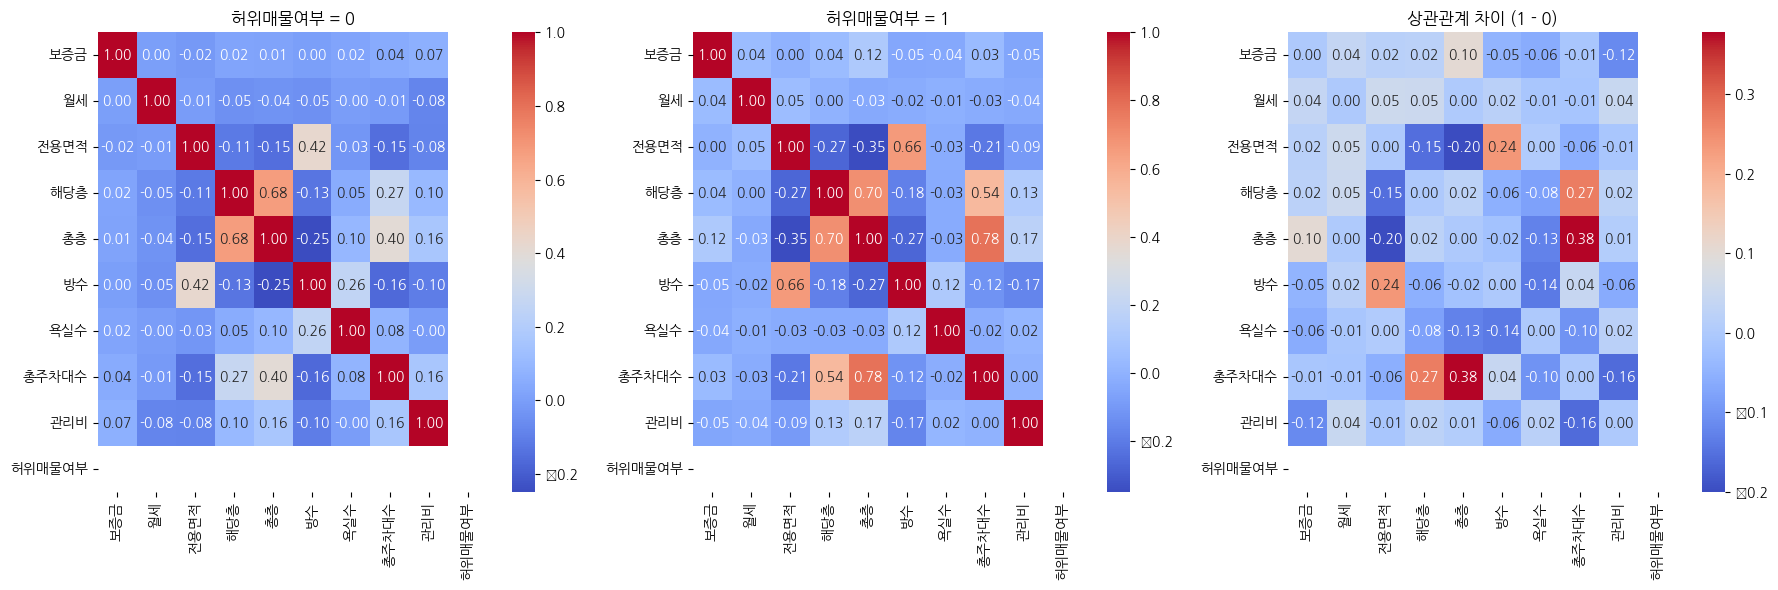

In [28]:
# 허위매불여부와 숫자 데이터 상관관계

# 문자 컬럼 삭제
drop_word_df = df.drop(columns=['ID', '매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼', '게재일'])

# '허위매물여부'가 0인 데이터
df_0 = drop_word_df[drop_word_df['허위매물여부'] == 0]

# '허위매물여부'가 1인 데이터
df_1 = drop_word_df[drop_word_df['허위매물여부'] == 1]

# 상관관계 계산
correlation_0 = df_0.corr()
correlation_1 = df_1.corr()

# 두 상관관계의 차이 계산
correlation_diff = correlation_1 - correlation_0

# 히트맵 시각화
plt.figure(figsize=(18, 6))

# 허위매물여부가 0일 때의 히트맵
plt.subplot(1, 3, 1)
sns.heatmap(correlation_0, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("허위매물여부 = 0")

# 허위매물여부가 1일 때의 히트맵
plt.subplot(1, 3, 2)
sns.heatmap(correlation_1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("허위매물여부 = 1")

# 두 상관관계의 차이를 나타내는 히트맵
plt.subplot(1, 3, 3)
sns.heatmap(correlation_diff, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("상관관계 차이 (1 - 0)")

plt.tight_layout()
plt.show()

In [29]:
# 타겟 데이터 개수 확인
target_column = '허위매물여부'
df[target_column].value_counts()

허위매물여부
0    2140
1     294
Name: count, dtype: int64

In [30]:
# === 레이블 인코딩 ===
from sklearn.preprocessing import LabelEncoder
label_encode_cols = ['중개사무소', '게재일', '제공플랫폼', '방향']
for col in label_encode_cols:
    le = LabelEncoder()
    combined_data = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined_data)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

NameError: name 'train' is not defined

In [ ]:
# === 원-핫 인코딩 ===
from sklearn.preprocessing import OneHotEncoder
one_hot_cols = ['매물확인방식', '주차가능여부']
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
train_encoded = one_hot_encoder.fit_transform(train[one_hot_cols])
test_encoded = one_hot_encoder.transform(test[one_hot_cols])
train = pd.concat([train.drop(columns=one_hot_cols), pd.DataFrame(train_encoded, index=train.index)], axis=1)
test = pd.concat([test.drop(columns=one_hot_cols), pd.DataFrame(test_encoded, index=test.index)], axis=1)

In [ ]:
# 데이터 분리
X = train.drop(columns=['허위매물여부'])
y = train['허위매물여부']

# 컬럼 이름을 문자열로 변환
X.columns = X.columns.astype(str)

# SMOTE로 데이터 증강
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

# 확인
print("After SMOTE, X_sm shape:", X_sm.shape)
print("After SMOTE, y_sm distribution:\n", pd.Series(y_sm).value_counts())


In [ ]:
# === 사용자 정의 F1 평가 지표 ===
def f1_metric(y_pred, data):
    y_true = data.get_label()
    y_pred_binary = (y_pred > 0.5).astype(int)
    f1 = f1_score(y_true, y_pred_binary)
    return 'f1', f1, True

In [ ]:
# === LightGBM 모델 학습 ===
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'class_weight': 'balanced',
    'seed': 42
}

In [ ]:
# Stratified K-Fold 교차 검증 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# oof_preds와 test_preds 초기화 (SMOTE 이후 데이터 크기로 조정)
oof_preds = np.zeros(len(X_sm))
test_preds = np.zeros(len(test))


for fold, (train_idx, val_idx) in enumerate(skf.split(X_sm, y_sm)):
    print(f"Fold {fold + 1}")
    X_train, X_val = X_sm.iloc[train_idx], X_sm.iloc[val_idx]
    y_train, y_val = y_sm.iloc[train_idx], y_sm.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        feval=f1_metric,  # 사용자 정의 F1 평가 함수 추가
        num_boost_round=1000,
        early_stopping_rounds=50,
        verbose_eval=100
    )
    
    # 예측 및 저장
    oof_preds[val_idx] = model.predict(X_val)  # val_idx는 SMOTE 이후 인덱스를 사용
    test_preds += model.predict(test) / skf.n_splits

In [ ]:
# === 검증 데이터 평가 ===
oof_preds_binary = (oof_preds > 0.5).astype(int)
print("OOF F1 Score:", f1_score(y_sm, oof_preds_binary, average='macro'))

In [ ]:
# === 혼동 행렬 시각화 ===
cm = confusion_matrix(y_sm, oof_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# === 테스트 데이터 예측 및 저장 ===
test_preds_binary = (test_preds > 0.5).astype(int)
submission = pd.DataFrame({'ID': test_id, '허위매물여부': test_preds_binary})
submission.to_csv('submission_2.csv', index=False)
print("Submission file saved to 'submission_2.csv'")

- 양의 관계
- 총층 - 총주차대수
- 해당층 - 총주차대수
- 방수 - 전용면적

- 음의 관계
- 총층 - 전용면적

- 보증금과 전용면적
- 월세와 전용면적
- 보증금, 월세, 전용면적
- 해당층 : 1층과 총층수의 꼭대기 층 (꼭대기, 지층, 원룸(5층 이하 건물), 승강기 여부)
- 방 개수와 전용면
- 방 개수와 보증금
- 방 개수와 월세
- 방 개수와 보증금, 월세 
- 전용면적과 관리비
- 총층수와 관리비
- 게재일 : 특별하게 월세가 오르는 부분(신학기, 연초, 연말)
